# Classifying Newswires: a multiclass classification example

In this notebook, we'll build a network to classify Reuters newswires into 46 mutually exclusive topics. This problem is a multiclass classification, more spesifically a single-label, multiclass classification cause each data points should be classified into only one category.

We will work with Reuters dataset, a set of short newswires and their topics, published by Reuters in 1986. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

The argument num_words=10000 restricts the data to the
10,000 most frequently occurring words found in the data.

In [2]:
len(train_data)

8982

In [3]:
len(test_data)

2246

In [4]:
train_data[0]

[1,
 2,
 2,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

Here’s how you can decode it back to words, in case you’re curious.

In [5]:
word_index = reuters.get_word_index()

In [6]:
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [7]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45—a topic index:

In [8]:
train_labels[10]

3

## Preparing the data

We vectorize the data.

In [9]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences),dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

Next we vectorize the labels. There are two ways:
* Cast the label list as an integer tensor
* Use one-hot encoding (used mainly for categorical data, also called categorical encoding.

In this case, one-hot encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index. Here’s an example:

In [10]:
def to_one_hot (labels,dimension=46):
    results = np.zeros((len(labels),dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

The built_in way to do this in Keras is:

In [11]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building the network

This topic-classification problem looks similar to the other notebook for movie review classification, but there is a new constraint here: here: the number of output classes has gone from 2 to 46. The dimensionality of the output space is much larger.

In a stack of Dense layers like that you’ve been using, each layer can only access information present in the output of the previous layer. If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each layer can potentially become an information bottleneck. In the previous example, you used 16-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, permanently dropping relevant information. For this reason you’ll use larger layers. 

Let’s go with 64 units.

In [12]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

* We end the network with a Dense layer of size 46. This means for each input sample, the network will output a 46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses the softmax activation. It means that the network will output a probability distribution over the 46 different output classes - for every input sample, the network will produce a 46-dimensional output vector, where output[i] is the probability that the sample belongs to the class i. The 46 scores will sum to 1.

Finally to compile the model the best loss function in this case is categorical crossentropy. It measures the distance between two probability distributions: here, between the probability distribution output by the network and the true distribution of the labels. By minimising the distance between these two distributions, you train the network to output something as close as possible to the true labels.

In [13]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## Validating your approach

Let’s set apart 1,000 samples in the training data to use as a validation set.

In [14]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

The training will take place for 20 epochs.

In [15]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val,y_val))

Epoch 1/20
16/16 [==============================] - 2s 50ms/step - loss: 2.5536 - accuracy: 0.5026 - val_loss: 1.6944 - val_accuracy: 0.6360
Epoch 2/20
16/16 [==============================] - 0s 28ms/step - loss: 1.3943 - accuracy: 0.7075 - val_loss: 1.2720 - val_accuracy: 0.7190
Epoch 3/20
16/16 [==============================] - 0s 26ms/step - loss: 1.0357 - accuracy: 0.7823 - val_loss: 1.1035 - val_accuracy: 0.7710
Epoch 4/20
16/16 [==============================] - 0s 26ms/step - loss: 0.8159 - accuracy: 0.8275 - val_loss: 1.0250 - val_accuracy: 0.7870
Epoch 5/20
16/16 [==============================] - 0s 27ms/step - loss: 0.6545 - accuracy: 0.8606 - val_loss: 0.9619 - val_accuracy: 0.7990
Epoch 6/20
16/16 [==============================] - 0s 26ms/step - loss: 0.5240 - accuracy: 0.8876 - val_loss: 0.9288 - val_accuracy: 0.7970
Epoch 7/20
16/16 [==============================] - 0s 28ms/step - loss: 0.4306 - accuracy: 0.9080 - val_loss: 0.9026 - val_accuracy: 0.8050
Epoch 8/20
16

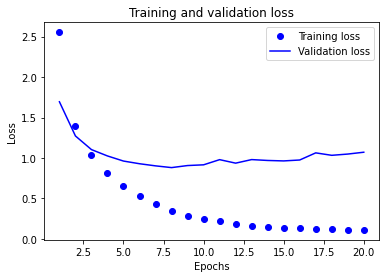

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

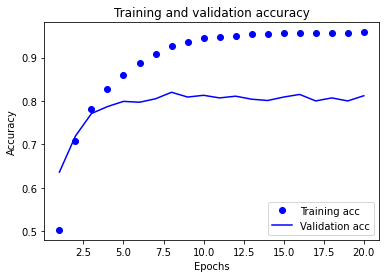

In [18]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We observe that the network begins to overfit after nine epochs. Cosewuently we train a new network for nine epochs and then evaluate it on the test set.

In [19]:
model = models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=(10000,)))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))

model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train,
          one_hot_train_labels,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test,one_hot_test_labels)

Epoch 1/9
18/18 [==============================] - 1s 22ms/step - loss: 2.5770 - accuracy: 0.5181
Epoch 2/9
18/18 [==============================] - 0s 21ms/step - loss: 1.3728 - accuracy: 0.7165
Epoch 3/9
18/18 [==============================] - 0s 21ms/step - loss: 1.0037 - accuracy: 0.7810
Epoch 4/9
18/18 [==============================] - 0s 21ms/step - loss: 0.7805 - accuracy: 0.8321
Epoch 5/9
18/18 [==============================] - 0s 21ms/step - loss: 0.6140 - accuracy: 0.8705
Epoch 6/9
18/18 [==============================] - 0s 21ms/step - loss: 0.4875 - accuracy: 0.8977
Epoch 7/9
18/18 [==============================] - 0s 21ms/step - loss: 0.3889 - accuracy: 0.9163
Epoch 8/9
18/18 [==============================] - 0s 21ms/step - loss: 0.3198 - accuracy: 0.9296
Epoch 9/9
71/71 [==============================] - 0s 3ms/step - loss: 0.9454 - accuracy: 0.7965


In [20]:
results

[0.9454484581947327, 0.7965271472930908]

The accuracy reached by the model is about 80%. So the results are pretty good compared to a random baseline (about 19%).

In [21]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.18788958147818344

## Generate predictions on new data

In [22]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 3ms/step


In [23]:
predictions[0].shape

(46,)

In [24]:
predictions[0]

array([6.04232882e-05, 8.92144599e-05, 2.87707917e-05, 8.61712098e-01,
       1.24548949e-01, 9.41986073e-05, 8.91712079e-06, 1.56250477e-04,
       2.30947672e-03, 1.59719802e-05, 8.08905388e-05, 1.74234374e-04,
       5.36460866e-05, 2.91717675e-04, 9.35736462e-05, 6.21744912e-05,
       1.27868238e-03, 2.44543445e-03, 3.04738860e-05, 2.76910258e-04,
       1.69215281e-03, 3.34537792e-04, 8.54851969e-05, 1.18979160e-03,
       5.48734761e-06, 1.89009166e-04, 1.32699452e-05, 2.26699740e-05,
       1.22773054e-05, 1.95183107e-04, 4.23032936e-04, 1.19967790e-05,
       1.73686822e-05, 9.17734269e-06, 4.20155993e-05, 8.30693079e-06,
       4.15689341e-04, 8.11760910e-05, 1.86065990e-05, 1.13777176e-03,
       3.16684600e-05, 1.10241555e-04, 2.04484513e-05, 2.69448410e-05,
       8.81324522e-05, 5.54219150e-06], dtype=float32)

In [25]:
predictions_percentage = predictions[0]*100

In [26]:
predictions_percentage

array([6.04232866e-03, 8.92144628e-03, 2.87707918e-03, 8.61712112e+01,
       1.24548950e+01, 9.41986032e-03, 8.91712087e-04, 1.56250484e-02,
       2.30947673e-01, 1.59719808e-03, 8.08905344e-03, 1.74234379e-02,
       5.36460849e-03, 2.91717667e-02, 9.35736485e-03, 6.21744897e-03,
       1.27868235e-01, 2.44543448e-01, 3.04738851e-03, 2.76910253e-02,
       1.69215277e-01, 3.34537774e-02, 8.54851957e-03, 1.18979156e-01,
       5.48734737e-04, 1.89009160e-02, 1.32699450e-03, 2.26699747e-03,
       1.22773054e-03, 1.95183102e-02, 4.23032939e-02, 1.19967794e-03,
       1.73686817e-03, 9.17734287e-04, 4.20155982e-03, 8.30693054e-04,
       4.15689349e-02, 8.11760873e-03, 1.86065992e-03, 1.13777176e-01,
       3.16684600e-03, 1.10241557e-02, 2.04484514e-03, 2.69448408e-03,
       8.81324522e-03, 5.54219121e-04], dtype=float32)

In [27]:
test_labels

array([ 3, 10,  1, ...,  3,  3, 24], dtype=int64)

In [28]:
np.argmax(predictions[0])

3

## Different way to handle the labels and the loss

Another way to encode the labels would be to cast them as
an integer tensor, like this:

In [29]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

So we have to change here the loss function. Instead of categorical_crossentropy we should use the sparse_categorical_crossentropy.

In [30]:
model.compile(optimizer='rmsprop',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test,y_test)

Epoch 1/9
18/18 [==============================] - 1s 22ms/step - loss: 0.2527 - accuracy: 0.9407
Epoch 2/9
18/18 [==============================] - 0s 22ms/step - loss: 0.1945 - accuracy: 0.9508
Epoch 3/9
18/18 [==============================] - 0s 21ms/step - loss: 0.1799 - accuracy: 0.9488
Epoch 4/9
18/18 [==============================] - 0s 21ms/step - loss: 0.1600 - accuracy: 0.9529
Epoch 5/9
18/18 [==============================] - 0s 21ms/step - loss: 0.1526 - accuracy: 0.9523
Epoch 6/9
18/18 [==============================] - 0s 21ms/step - loss: 0.1402 - accuracy: 0.9527
Epoch 7/9
18/18 [==============================] - 0s 21ms/step - loss: 0.1367 - accuracy: 0.9548
Epoch 8/9
18/18 [==============================] - 0s 22ms/step - loss: 0.1289 - accuracy: 0.9547
Epoch 9/9
71/71 [==============================] - 0s 3ms/step - loss: 1.2113 - accuracy: 0.7836


In [31]:
results

[1.2112807035446167, 0.7836152911186218]

This new loss function is still mathematically the same as  categorical_crossentropy; it just has a different interface.

## Having sufficiently large intermediate layers

Let's see what happens when we introduce a information bottleneck by having intemediate layers that are significantly less than 46-dimensional: for example 4-dimensional

In [32]:
model_new = models.Sequential()
model_new.add(layers.Dense(64,activation='relu',input_shape=(10000,)))
model_new.add(layers.Dense(4,activation='relu'))
model_new.add(layers.Dense(46,activation='softmax'))

In [38]:
model_new.compile(optimizer='rmsprop',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
model_new.fit(partial_x_train,
             partial_y_train,
             epochs=20,
             batch_size=128,
             validation_data=(x_val,y_val))

Epoch 1/20
63/63 [==============================] - 2s 22ms/step - loss: 0.2948 - accuracy: 0.9142 - val_loss: 3.9734 - val_accuracy: 0.6880
Epoch 2/20
63/63 [==============================] - 1s 13ms/step - loss: 0.2873 - accuracy: 0.9153 - val_loss: 3.9930 - val_accuracy: 0.6890
Epoch 3/20
63/63 [==============================] - 1s 13ms/step - loss: 0.2844 - accuracy: 0.9151 - val_loss: 3.9845 - val_accuracy: 0.6960
Epoch 4/20
63/63 [==============================] - 1s 13ms/step - loss: 0.2811 - accuracy: 0.9168 - val_loss: 3.8936 - val_accuracy: 0.6910
Epoch 5/20
63/63 [==============================] - 1s 13ms/step - loss: 0.2774 - accuracy: 0.9159 - val_loss: 4.0656 - val_accuracy: 0.6860
Epoch 6/20
63/63 [==============================] - 1s 13ms/step - loss: 0.2764 - accuracy: 0.9177 - val_loss: 4.2179 - val_accuracy: 0.6850
Epoch 7/20
63/63 [==============================] - 1s 14ms/step - loss: 0.2748 - accuracy: 0.9172 - val_loss: 4.3176 - val_accuracy: 0.6800
Epoch 8/20
63

In [39]:
results = model_new.evaluate(x_test,one_hot_test_labels)

71/71 [==============================] - 0s 3ms/step - loss: 5.6948 - accuracy: 0.6714


In [40]:
results

[5.694803714752197, 0.6714158654212952]

It is apparent a absolute drop of the validation accuracy. This drop
is mostly due to the fact that you’re trying to compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional. The network is able to cram most of the necessary information into these four-dimensional representations, but not all of it.

## Further experiments
* Try using larger or smaller layers: 32 units, 128 units, and so on.
* You used two hidden layers. Now try using a single hidden layer, or three hidden layers.